In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

% matplotlib inline

In [143]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib.cm as cm

In [5]:
loc = r'C:\Users\c0w00f8.WMSC\Documents\Coursera\1. Machine Learning\machine-learning-ex7\ex7\ex7data1.mat'
data1 = loadmat(loc)
data1 = data1['X']
data1.shape

(50, 2)

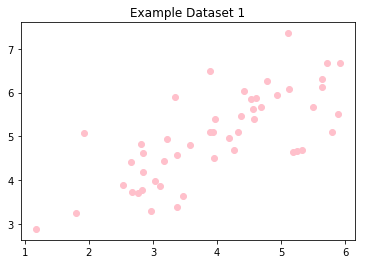

In [8]:
# visualize data1
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
title = ax.set_title('Example Dataset 1')
plot = ax.scatter(data1[:, 0], data1[:, 1], marker = 'o', c = 'pink')

In [34]:
def featureNormalize(x):
    mean = x.mean(axis = 0)
    std = x.std(axis = 0)
    x_norm = (x - mean) / std
    return x_norm, mean, std

In [50]:
data1_norm, mu, sig = featureNormalize(data1)

numpy.ndarray

In [40]:
def pca(x):
    # compute covariance
    m = x.shape[0]
    cov = np.dot(x.T, x) / m
    
    # compute u
    u, s, vh = np.linalg.svd(cov, full_matrices = True)
    
    return u, s

In [51]:
data1_u, data1_s = pca(data1_norm)
data1_u

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

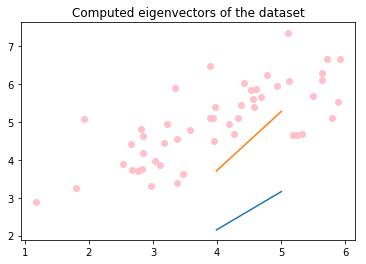

In [64]:
# visualize eigenvectors of dataset1
# need to revise
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
title = ax.set_title('Computed eigenvectors of the dataset')
plot = ax.scatter(data1[:, 0], data1[:, 1], marker = 'o', c = 'pink')
line1 = ax.plot(mu, mu + 1.5 * data1_s[0] * data1_u[:, 0]) # ???
line2 = ax.plot(mu, mu + 1.5 * data1_s[1] * data1_u[:, 1]) # ???

In [80]:
def projectData(x, k):
    m = x.shape[0]
    cov = np.dot(x.T, x) / m
    u, s, vh = np.linalg.svd(cov)
    
    u_k = u[:, :k]
    x_reduced = x.dot(u_k)
    
    return x_reduced

In [83]:
testP = projectData(data1_norm, 1)
testP[0]

array([1.49631261])

In [93]:
def recoverData(x_reduced, u, k):
    x_rec = x_reduced.dot(u[:, :k].T)
    return x_rec

In [95]:
testR = recoverData(testP, data1_u, 1)
testR[0, :]

array([-1.05805279, -1.05805279])

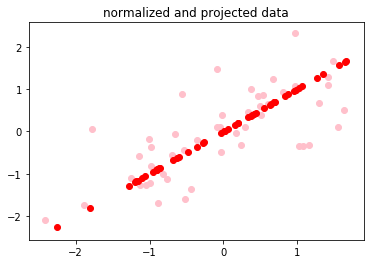

In [104]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
title = ax.set_title('normalized and projected data')
plot1 = ax.scatter(data1_norm[:, 0], data1_norm[:, 1], marker = 'o', c = 'pink')
plot2 = ax.scatter(testR[:, 0], testR[:, 1], marker = 'o', c = 'red')


In [108]:
# face data
loc_face = r'C:\Users\c0w00f8.WMSC\Documents\Coursera\1. Machine Learning\machine-learning-ex7\ex7\ex7faces.mat'
faces = loadmat(loc_face)
faces = faces['X']
faces.shape

(5000, 1024)

In [117]:
def showFace(x):
    n = 32
    m = x.shape[0]
    
    fig = plt.figure(figsize=(8, 8))
    for i in range(m):
        ax = fig.add_subplot(3, 4, i+1)
        x_reshape = x[i, :].reshape((n, n))
        face = plt.imshow(x_reshape.T, cmap='gray')


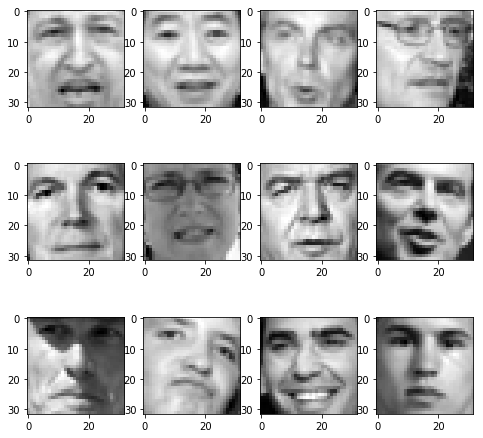

In [118]:
rand_idx = np.random.choice(faces.shape[0], 12, replace=False)
faces_sub = faces[rand_idx, :]
showFace(faces_sub)

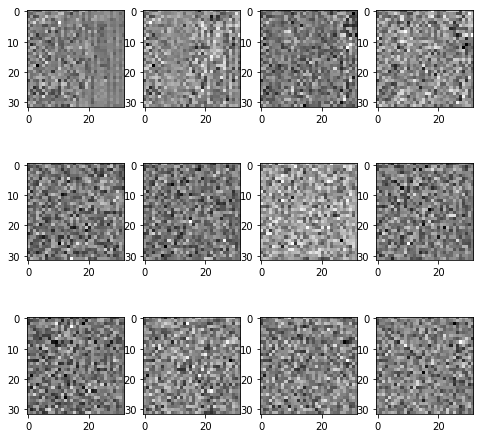

In [120]:
faces_norm, faces_mu, faces_sig = featureNormalize(faces)
faces_u, faces_s = pca(faces_norm)
showFace(faces_u[:12, :])

In [121]:
k = 100
faces_reduced = projectData(faces_norm, k)
faces_rec = recoverData(faces_reduced, faces_u, k)

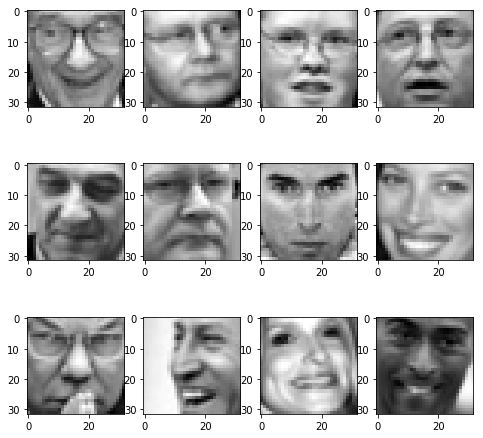

In [123]:
showFace(faces[:12, :])

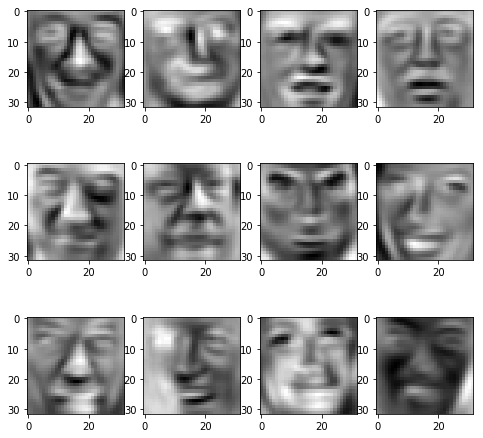

In [122]:
showFace(faces_rec[:12, :])

In [136]:
# PCA for visualization
loc = r'C:\Users\c0w00f8.WMSC\Documents\Coursera\1. Machine Learning\machine-learning-ex7\ex7\bird_small.png'
bird = mpimg.imread(loc)
bird.shape

(128, 128, 3)

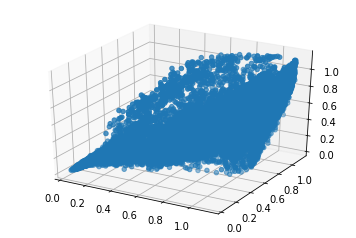

In [128]:
# 3D plot for bird image points
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot = ax.scatter(bird[:, :, 0], bird[:, :, 1], bird[:, :, 2], marker='o')

In [139]:
def initCentroids(x, k):
    m = x.shape[0]
    rand_idx = np.random.choice(m, k, replace=False)
    centroids = x[rand_idx, :]
    
    # another way to generate random k idx without replacement
    # idx = np.random.permutation(np.arange(m))[:k]
    
    return centroids

In [140]:
def findClosestCentroids(x, centroids):
    k = centroids.shape[0]
    dist = np.zeros((x.shape[0], k))
    
    for i in range(x.shape[0]):
        for j in range(k):
            dist[i, j] = np.linalg.norm(x[i, :] - centroids[j, :]) ** 2
    
    idx = np.argmin(dist, axis = 1)
    cost = (np.min(dist, axis = 1)).sum()
    
    return idx, cost

In [141]:
def computeCentroids(x, idx, k):
    centroids = np.zeros((k, x.shape[1]))
    
    for i in range(k):
        x_sub = x[(idx == i), :]
        #centroids[i, :] = x_sub.sum(axis = 0) / x_sub.shape[0]
        centroids[i, :] = x_sub.mean(axis = 0)
    
    return centroids 

In [130]:
def runKmeans(x, init_centroids, max_iters, plot):
    k = init_centroids.shape[0]
    cent = init_centroids
    
    # keep idx and cent for plots
    idx_mat = np.zeros((x.shape[0], max_iters))
    cent_mat = np.zeros((max_iters, k, x.shape[1]))
    
    for i in range(max_iters):
        
        # assign centroid for each x
        x_idx, cost = findClosestCentroids(x, cent)
        
        # compute new centroid
        cent = computeCentroids(x, x_idx, k)
        
        # keep x_idx and cent for plot use
        idx_mat[:, i] = x_idx
        cent_mat[i, :, :] = cent
        
    if plot == True:
        #plotKmeans(x, cent_mat, idx_mat)
        return cent_mat, idx_mat

    else: return cent, x_idx, cost

In [137]:
# reshape
m = bird.shape[0] * bird.shape[1]
bird_data = bird.reshape((m, bird.shape[2]))
bird_data.shape

(16384, 3)

In [142]:
k = 16
max_iters = 10
init_cent = initCentroids(bird_data, k)
plot = False

cent, idx, cost = runKmeans(bird_data, init_cent, max_iters, plot)

In [165]:
idx = idx.reshape((128, 128))
idx.shape
idx[0, 0]

12

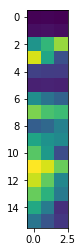

In [147]:
plt.imshow(cent)

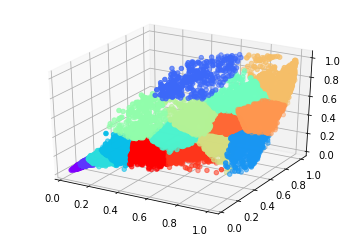

In [174]:
# 3D plot for bird image points

colors = cm.rainbow(np.linspace(0, 1, k))

fig = fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
for i in range(k):
    bird_sub = bird[idx==i, :]
    plot = ax.scatter(bird_sub[:, 0], bird_sub[:, 1], bird_sub[:, 2], c=colors[i])
    

#plot = ax.scatter(bird[:, :, 0], bird[:, :, 1], bird[:, :, 2], marker='o')

In [175]:
bird_norm, bird_mu, bird_sig = featureNormalize(bird_data)
bird_u, bird_s = pca(bird_norm)
k = 2
bird_reduced = projectData(bird_norm, k)
bird_rec = recoverData(bird_reduced, bird_u, k)

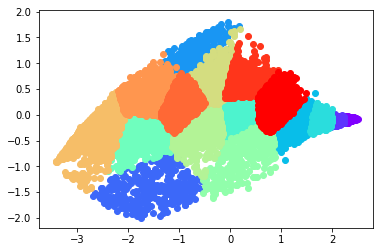

In [179]:
# plot 2d data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(16):
    bird_sub = bird_reduced[idx.flatten() == i]
    plot = ax.scatter(bird_sub[:, 0], bird_sub[:, 1], c=colors[i])